# Plant pathology 2020

# Setting up env and downloading dataset

In [2]:
import os
from pathlib import Path

def check_environment() -> bool:
    """Check if the notebook is running in Google Colab or not.

    Returns:
        bool: True if running in Colab, False otherwise.
    """
    return bool(os.getenv("COLAB_RELEASE_TAG"))

def download_utils(colab_flag):
  """Function to clone the required utils .py helper module if running in colab

  Returns:
    None
  """
  if colab_flag:
    !curl -o /content/setup_utils.py https://raw.githubusercontent.com/jalkestrup/fastai_course/main/10_final_project/setup_utils.py
  else:
    return


In [3]:
colab_flag = check_environment()
download_utils(colab_flag)

In [4]:
#Helper functions for setting up the environment and downloading the dataset based on compute environment
from setup_utils import install_libraries, download_kaggle_data, set_kaggle_credentials

install_libraries(colab_flag)

set_kaggle_credentials(colab_flag)

kaggle_dataset = 'plant-pathology-2020-fgvc7'
download_kaggle_data(kaggle_dataset)

Running in local environment...
Sucesfully set kaggle credentials
Data folder already exists


# Inspecting the data

In [5]:
import timm
from fastai.vision.all import *

path = Path('plant-pathology-2020-fgvc7')

image_path = path/'images'
image_files = get_image_files(image_path)

Shape of image : (1365, 2048)


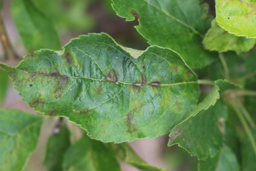

In [6]:
img = PILImage.create(image_files[3])
print(f'Shape of image : {img.shape}')
img.to_thumb(256)

The images are of similar size (1365 x 2048), but a few are rotated (2048x1365). To correct this we will create a new function that checks all images, and rotate those that are an exact transpose of the normal image-size. We may stil risk that the final test set contains images of a completely different size.



## Loading resized images
From previous script I have resized the images to 266x400 size, and saved them on Google Drive. We load these for experimentation

In [7]:
import multiprocessing
from fastcore.parallel import *

n_cores = multiprocessing.cpu_count()
print(f'Number of cores {n_cores}')

def check_size(img):
    return PILImage.create(img).shape

Number of cores 16


In [8]:
"""
dest = path/'small_images'
resize_images(path/'images', max_size=400, dest=dest, recurse=True)

#Save resized images to drive for fast reload in new instance
Copy images from path/small_images to /content/drive/MyDrive/dtu/fastAI/10_final_project
!cp -r '/content/plant-pathology-2020-fgvc7/small_images' /content/drive/MyDrive/dtu/fastAI/10_final_project
"""
#Copy prev resized images from drive to Colab
#Create new folder in /content/plant-pathology-2020-fgvc7/small_images
if colab_flag == True:
    !mkdir /content/plant-pathology-2020-fgvc7/small_images
    !cp -r /content/drive/MyDrive/dtu/fastAI/10_final_project/small_images/. '/content/plant-pathology-2020-fgvc7/small_images'
    #Check the size of a photo in the small_images
    image_path_small = path/'small_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()
else:
    #For local dev (no GPU) make tiny images for faster training, relatively fast due to 16 cores
    dest = path/'tiny_images'
    if not os.path.exists(dest):
        os.mkdir(dest)
        resize_images(path/'images', max_size=128, dest=dest, recurse=True)
    image_path_small = path/'tiny_images'
    image_files_small = get_image_files(image_path_small)
    sizes = parallel(check_size, image_files_small, n_workers=n_cores)
    pd.Series(sizes).value_counts()


## Setting up labels

In [9]:
#Inspect the labels of the dataset by loading the csv file into a pandas dataframe
df_train = pd.read_csv(f'{path}/train.csv')
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


In [10]:
#Create a new column with decoded labels for each image based on the one-hot encoded labels by using the np.argmax() function on column 2 to 5
#Set the label string in the new label column as the column name where the value is 1

df_train['label'] = df_train.apply(lambda col: df_train.columns[1:5][np.argmax(col.values[1:5])], axis=1)
df_train.head()

,image_id,healthy,multiple_diseases,rust,scab,label
0,Train_0,0,0,0,1,scab
1,Train_1,0,1,0,0,multiple_diseases
2,Train_2,1,0,0,0,healthy
3,Train_3,0,0,1,0,rust
4,Train_4,1,0,0,0,healthy


In [11]:
df_train.label.value_counts()

label
rust                 622
scab                 592
healthy              516
multiple_diseases     91
Name: count, dtype: int64

# Model experimentation

In [12]:
#Function for collecting and emptying GPU Cache

if colab_flag:
    !pip install pynvml
    import gc
    def report_gpu():
        print(torch.cuda.list_gpu_processes())
        gc.collect()
        torch.cuda.empty_cache()

    report_gpu()

## Setting up W&B and model function

In [32]:
if colab_flag:
    !pip install -Uq wandb
    #Silence Wandb printouts
    os.environ["WANDB_SILENT"] = "true"
    import wandb
    !wandb login

**Note to self on normalization** It is common to normalize the image data prior training, something that is even more important when using pretrained models. When using pretrained models the normalization should be based on the same statistics that the model was trained on. Using the Visionlearner from FastAI automatically take care of normalization, typically just based on ImageNet statistics.
```

In [33]:
#Function for easily swapping item transform and aug
#Added early stopping for longer train runs
from fastai.callback.wandb import *

def train_model(arch, item, batch, epochs, batch_size=64, learning_rate=0.005, accum_steps=1, wandb_flag=False):

  config = {
      'arch': arch,
      'item_tfms_size': str(item.size),
      'item_tfms_method': item.method,
      'item_tfms_padding': item.pad_mode,
      'learning_rate': learning_rate,
      'epochs': epochs,
  }

  if wandb_flag:
    wandb.init(project='apple_disease', entity='jealk', group='model_architecture', config=config)

  dls = ImageDataLoaders.from_df(df_train,
                               path=path,
                               fn_column = 'image_id',
                               label_col='label',
                               folder = 'tiny_images',
                               suff='.jpg',
                               item_tfms=item,
                               bs=batch_size//accum_steps,
                               batch_tfms=batch,
                               )
  #Per default for categorical variables, CrossEntropy is used as loss function
  learn = vision_learner(dls,arch,metrics=error_rate).to_fp16()

  early_stopping_cb = EarlyStoppingCallback(monitor='error_rate', min_delta=0.0, patience=3)

  callbacks = [early_stopping_cb]
  if wandb_flag:
    callbacks.append(WandbCallback(log=None,log_preds=False,log_model=False))

  if accum_steps > 1:
    gradient_accumulation_cb = GradientAccumulation(accum_steps)
    callbacks.append(gradient_accumulation_cb)

  learn.fine_tune(epochs,learning_rate, cbs=callbacks)

  if wandb_flag:
    wandb.finish()
    
  return learn, dls

In [19]:
arch = 'convnext_small_in22k'

learn,dls = train_model(arch,
                        item=Resize(128, method='crop'),
                        batch=aug_transforms(size=64, min_scale=0.75),
                        epochs=3)


/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name convnext_small_in22k to current convnext_small.fb_in22k.
  model = create_fn(
/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


epoch,train_loss,valid_loss,error_rate,time
0,1.608993,1.444903,0.362637,00:38


epoch,train_loss,valid_loss,error_rate,time
0,0.953563,0.860809,0.271978,01:11
1,0.811602,0.690946,0.219780,01:10
2,0.678217,0.634917,0.214286,01:09


# TTA
 test time augmentation (TTA): During inference or validation, creating multiple versions of each image, using data augmentation, and then taking the average or maximum of the predictions for each augmented version of the image.

# Creating submission CSV

In [20]:
#Load the list of test images into a pandas dataframe
df_test = pd.read_csv(f'{path}/test.csv')
df_test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


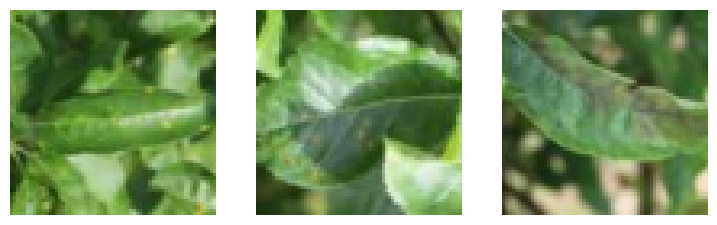

In [21]:
#Load the test images into a dataloader
test_dl = dls.test_dl(df_test)
test_dl.show_batch(max_n=3)

In [22]:
#Do predictions on test set
preds,_ = learn.get_preds(dl=test_dl)

/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/home/jealk/mambaforge/envs/fastai/lib/python3.11/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [30]:
#Append pd.DataFrame(preds) to the df_test dataframe 
df_test = pd.concat([df_test, pd.DataFrame(preds)], axis=1)

#Set the column names to that of df_train labels
df_test.columns = df_train.columns[:5]
df_test.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.006928,0.056002,0.832398,0.104673
1,Test_1,0.071441,0.011671,0.897612,0.019276
2,Test_2,0.000528,0.000847,0.000003,0.998621
3,Test_3,0.995883,0.000201,0.003608,0.000308
4,Test_4,0.000008,0.001131,0.998729,0.000132


In [31]:
#Create a csv file of the dataframe without the index column and save it on the root folder
df_test.to_csv('submission.csv', index=False)